Contamos con datos de transacciones diarias, pero es importante elegir una escala en la que no se introduzca ruido innecesario mientras que se mantienen las tendencias estacionales de los datos (para no perder información importante). Por tanto, se realiza a continuación un estudio para elegir la granularidad temporal con la que trabajaremos: diaria, mensual o anual.

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
from skforecast.plot import set_dark_theme
set_dark_theme()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks

In [2]:
def preprocess_data(data, remove_outliers=True):    
    if remove_outliers:
        mask = ((data["is_top_outlier"] != 1) | (data["is_bottom_outlier"] != 1))
    else:
        mask = pd.Series([True] * len(data), index=data.index)

    data = data.\
        loc[mask, ["Date.of.Transfer", "Price"]].\
        rename(columns={"Date.of.Transfer": "date"}).\
        groupby(["date"]).mean(numeric_only=True)
    
    return data

In [3]:
#  --- Train data set ---
# https://stackoverflow.com/questions/59098785/is-it-possible-to-read-parquet-files-in-chunks

parquet_file = pq.ParquetFile('../../data/parquet/train/train.parquet')
n_batches_test = np.array([1 for _ in parquet_file.iter_batches()]).sum()

for idx, batch in enumerate(parquet_file.iter_batches()):
    print(f"\rBatch {idx} of {n_batches_test-1}", end="")

    if idx == 0:
        data_train = preprocess_data(batch.to_pandas()).reset_index()
    
    else:
        batch_df = preprocess_data(batch.to_pandas()).reset_index()    
        data_train = pd.concat([data_train, batch_df], axis=0)

data_train = data_train.rename(columns={"Date.of.Transfer": "date"}).\
    groupby(["date"]).mean(numeric_only=True)
data_train.head(3)

Batch 392 of 392

,Price
date,
1995-01-01,63685.446429
1995-01-02,76743.308824
1995-01-03,65094.143678


In [4]:
#  --- Test data set ---
# https://stackoverflow.com/questions/59098785/is-it-possible-to-read-parquet-files-in-chunks

parquet_file = pq.ParquetFile('../../data/parquet/test/test.parquet')
n_batches_test = np.array([1 for _ in parquet_file.iter_batches()]).sum()

for idx, batch in enumerate(parquet_file.iter_batches()):
    print(f"\rBatch {idx} of {n_batches_test-1}", end="")

    if idx == 0:
        data_test = preprocess_data(batch.to_pandas()).reset_index()
    
    else:
        batch_df = preprocess_data(batch.to_pandas()).reset_index()    
        data_test = pd.concat([data_test, batch_df], axis=0)

data_test = data_test.rename(columns={"Date.of.Transfer": "date"}).\
    groupby(["date"]).mean(numeric_only=True)
data_test.head(3)

Batch 32 of 32

,Price
date,
2021-01-01,343402.957447
2021-01-02,245342.307692
2021-01-03,307219.444444


In [5]:
# --- All data ---
data = pd.concat([data_train, data_test], axis=0)
data_d = data.asfreq("D").fillna(method='ffill')["Price"] # fill first case if is NA too
data_m = data.asfreq("MS").fillna(method='ffill')["Price"] # fill first case if is NA too
data_a = data.asfreq("AS").fillna(method='ffill')["Price"] # fill first case if is NA too
del data_train, data_test, data

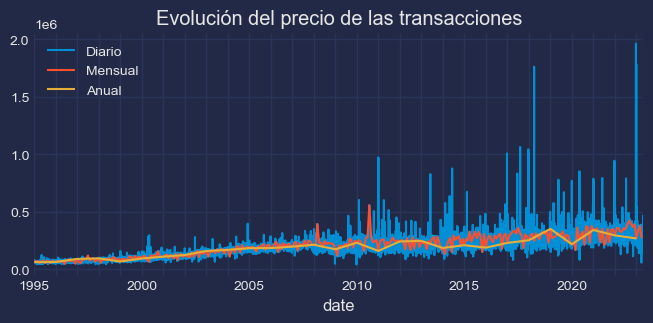

In [6]:
# --- Plot ---
fig, ax=plt.subplots(figsize=(7, 3))
data_d.plot(ax=ax, label='Diario')
data_m.plot(ax=ax, label='Mensual')
data_a.plot(ax=ax, label='Anual')
ax.set_title('Evolución del precio de las transacciones')
ax.legend()
plt.show()

In [7]:
# To R
temp1 = pd.DataFrame(data_d).reset_index()
temp1["precision"] = "Diario"

temp2 = pd.DataFrame(data_m).reset_index()
temp2["precision"] = "Mensual"

temp3 = pd.DataFrame(data_a).reset_index()
temp3["precision"] = "Anual"

pd.concat([temp1, temp2, temp3], axis=0).to_csv("../../output/series-temporales/analisis-granularidad/granularidad_price.csv")

# Variabilidad de los datos a diferentes escalas

Vamos a calcular la disperisón de los datos para las diferentes escalas de tiempo y las compararemos para ver si alguna introduce un ruido notablemente superior. Visualmente, podemos esperar sea la escala diaria la que destaque.

In [8]:
results = pd.DataFrame(columns=("Media", "Varianza", "Desviación estándar"), index=("Diario", "Mensual", "Anual"))

def variability(pd_series):
    return np.array(
        [pd_series.mean(), pd_series.var(), pd_series.std()]
    )

results.loc["Diario", :] = variability(data_d)
results.loc["Mensual", :] = variability(data_m)
results.loc["Anual", :] = variability(data_a)

results = results.melt()
results["precision"] = ("Diario","Mensual","Anual") * 3
results.to_csv("../../output/series-temporales/analisis-granularidad/volatilidad.csv")


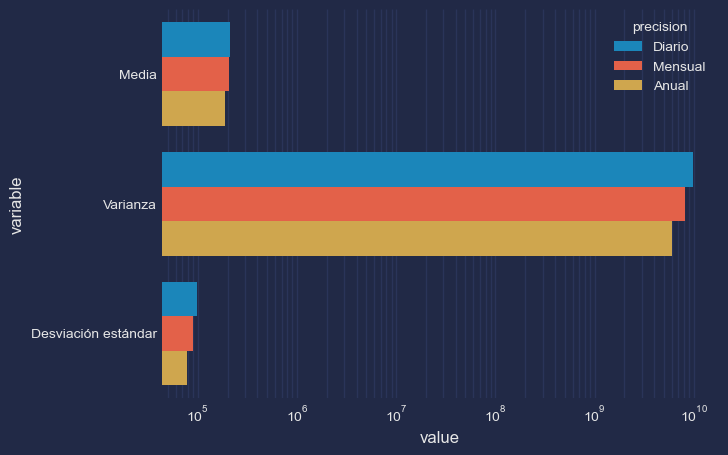

In [9]:
sns.barplot(y="variable", x="value", hue="precision", data=results)
plt.xscale('log')  

<Axes: xlabel='variable', ylabel='value'>

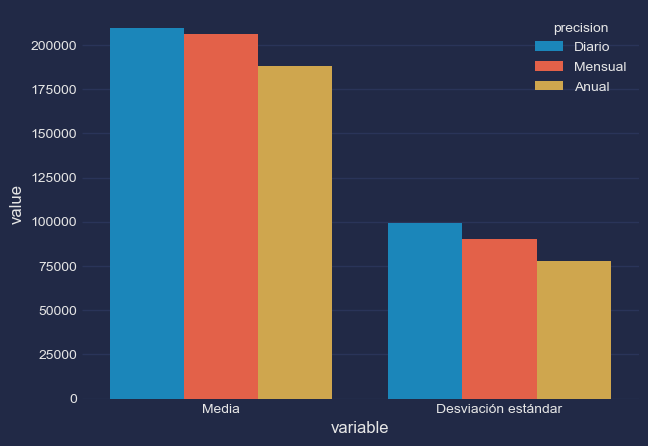

In [10]:
sns.barplot(x="variable", y="value", hue="precision", data=results.loc[results["variable"]!="Varianza"])

Aunque la media se mantiene similar en las tres, la volatilidad aumenta rápidamente con la precisión temporal. No obstante, el aumento no es tan drástico como para descartar aún la escala diaria, que es la que mayor dispersión presenta.

# Análisis de autocorrelaciones

Vamos a utilizar diferentes retrasos temporales (lags) para estudiar los posibles patrones en los datos. Si se observan patrones diarios, podría ser conveniente mantenernos en esa escala. Si no, podríamos reducirla para mitigar el ruido.

In [11]:
from statsmodels.tsa.stattools import acf, pacf

temp = pd.DataFrame(acf(data_d, nlags=90)).reset_index()
temp.columns = ("lags", "value")
temp.to_csv("../../output/series-temporales/analisis-granularidad/acf_daily.csv")

temp = pd.DataFrame(pacf(data_d, nlags=90)).reset_index()
temp.columns = ("lags", "value")
temp.to_csv("../../output/series-temporales/analisis-granularidad/pacf_daily.csv")

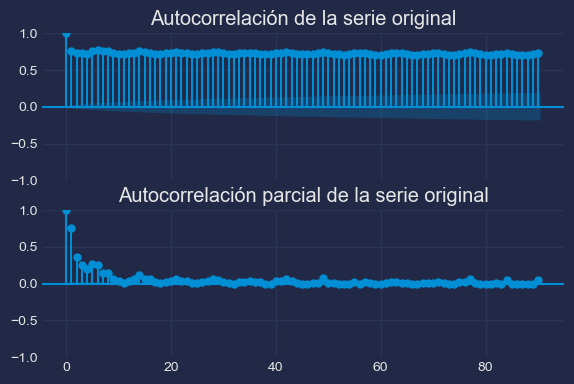

In [12]:
# Autocorrelation plot for original and differentiated series (d=1)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data_d, ax=axs[0], lags=90, alpha=0.05)
axs[0].set_title('Autocorrelación de la serie original')
plot_pacf(data_d, ax=axs[1], lags=90, alpha=0.05)
axs[1].set_title('Autocorrelación parcial de la serie original')
plt.show()

+ Parecen haber oscilaciones en la parte ACF. Podemos contar el número de picos en el intervalo entre el cero (que podemos considerarlo el primer pico) y el que casi se da en 90 (que es el siguiente pico que aproximadamente coincide con las guías). Hay 14 picos, por lo que estos se producen cada 6 o 7 días. Esto muestra una posible tendencia semanal.

+ No obstante, también se aprecia que hay un lento decrecimiento, lo que indica que predominan las tendencias a largo plazo frente a las dependencias a corto plazo.

+ Para la autocorrelación parcial (PACF) se tiene un valor especialmente alto en 1, lo que nos indica que el valor de un día concreto está altamente correlado con el del día anterior.

En definitiva: dada la ausencia de periodicidad de ningún tipo en el término ACF y la presencia del pico en 1 para PACF, se deduce que la escala temporal más adecuada para explicar patrones a corto plazo es la diaria. No obstante, también podríamos considerar la escala mensual, ya que suavizará los valores de la escala diaria, permitiendo centrarnos en patrones más a largo plazo. Al mismo tiempo, se espera que el suavizado que introduce la escala anual limite la capacidad de predicción del modelo, dado que está perdiendo la mayoría de información de la que dispone.

# Descomposición estacional de la serie temporal diaria

Vamos a utilizar una transformación en series de Fourier para extraer las frecuencias correspondientes a los ciclos que se dan en los datos. La interpretación del resultado es sencilla, ya que estamos trabajando en días, por lo que solo tendremos que tomar las frecuencias en las que se obtengan picos visibles y hacer la operación:

$ Perido = \frac{1}{Frecuencia} $,

lo que nos devuelve el número de días que corresponde a cada ciclo (por ejemplo, un ciclo de 7 días nos indica que hay un patrón semanal en los datos).

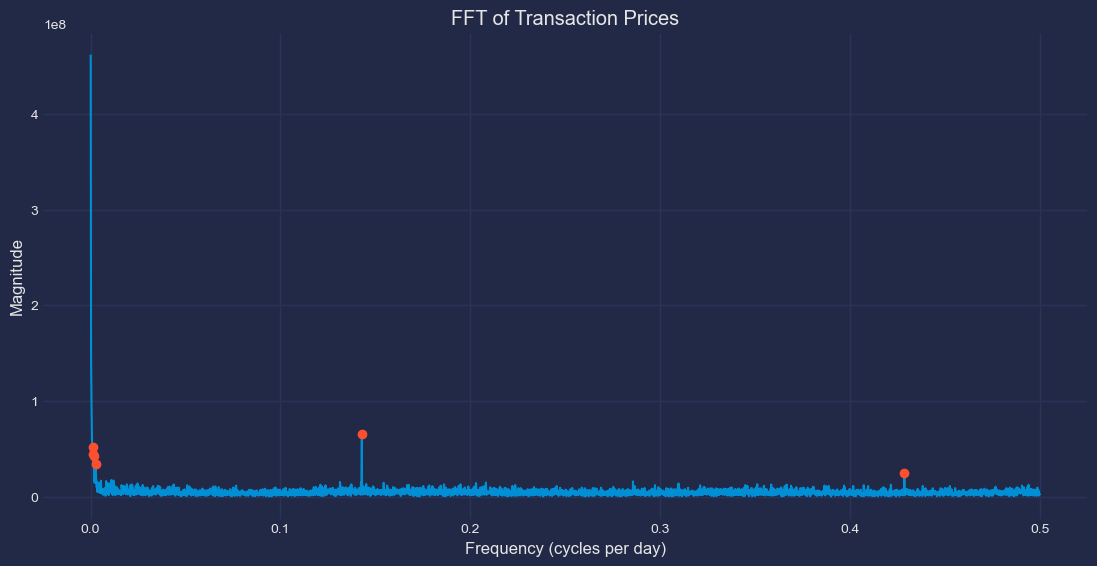

In [15]:
# --- Fast Fourier Transform (FFT) ---
fft_values = np.fft.fft(data_d)
fft_frequencies = np.fft.fftfreq(len(fft_values), d=1)  # 'd=1' because we have daily data

fft_magnitudes = np.abs(fft_values)

y = fft_magnitudes[1:len(fft_magnitudes)//2]

# --- Plot the FFT result ---
plt.figure(figsize=(12, 6))
x = fft_frequencies[1:len(fft_frequencies)//2]
y = fft_magnitudes[1:len(fft_magnitudes)//2]

# Finding all peaks
peaks, properties = find_peaks(y)

# Sorting peaks by height and selecting the top N
N = 6
top_n_peaks = peaks[np.argsort(y[peaks])[-N:]]  # Adjust `N` to your desired number of peaks
np.savetxt("../../output/series-temporales/analisis-granularidad/peaks_fft.csv", 
           top_n_peaks, delimiter=",")

pd.DataFrame({"frequency":x, "value":y}).to_csv("../../output/series-temporales/analisis-granularidad/fft.csv")

# Plot
plt.plot(x, y)  # Ignore the zero frequency term
plt.plot(x[top_n_peaks], y[top_n_peaks], 'o')

plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Magnitude')
plt.title('FFT of Transaction Prices')
plt.show()

In [25]:
np.sort(1 / x[top_n_peaks])

array([  2.33340853,   6.99864682, 369.42857143, 608.47058824,
       738.85714286, 940.36363636])

Se observan patrones diarios (entorno a 2 días), semanales, anuales (entorno a los múltiplos de 365) y otros que marcan tendencias a largo plazo sin especificar ciclos.

# Copio el procesamiento mensual y lo hago diario

Vamos a seguir como referencia la información de la página https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python, en la que se muestra la manera de trabajar en Python con series temporales. Vamos a trabajar con una serie temporal autorregresiva, es decir, que modeliza la serie basándose únicamente en su comportamiento pasado. Nos centraremos por tanto en modelos ARIMA y SARIMA.

Para ello, vamos a centrarnos en identificar los siguientes parámetros:

+ $p$: orden (número de lags) de la parte autorregresiva del modelo.

+ $d$: grado de diferenciación, es decir, número de veces que se restan los valores pasados a los datos.

+ $q$: orden de la parte de la media móvil del modelo.

+ $P$: orden de la parte estacional del modelo.

+ $D$: grado de diferenciación de la parte estacional del modelo.

+ $Q$: orden de la parte de la media móvil de la parte estacional del modelo.

+ $m$: número de periodos en cada estación.

In [77]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
set_dark_theme()
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

# Other
import pyarrow.parquet as pq
import pickle
from io import StringIO
import contextlib
import re

# Datos

Los datos vienen preprocesados del documento principal. Tenemos:

+ Conjunto de entrenamiento: 5% del total de datos de entrenamiento, desde 1995 hasta 2020.
+ Conjunto de validación: 5% del total de datos de test, desde 2021 hasta 2023.
+ Conjunto de test: total de los datos de test, desde 2021 hasta 2023.

In [78]:
#  --- Test data set ---
# https://stackoverflow.com/questions/59098785/is-it-possible-to-read-parquet-files-in-chunks

parquet_file = pq.ParquetFile('../../data/parquet/test/test.parquet')
n_batches_test = np.array([1 for _ in parquet_file.iter_batches()]).sum()

for idx, batch in enumerate(parquet_file.iter_batches()):
    print(f"\rBatch {idx} of {n_batches_test-1}", end="")

    if idx == 0:
        data_test = batch.to_pandas()
    
    else:
        batch_df = batch.to_pandas()    
        data_test = pd.concat([data_test, batch_df], axis=0)

data_test.head(3)

Batch 32 of 32

,Price,Date.of.Transfer,Property.Type,Old.New,Duration,Town.City,District,County,org_property_type,org_duration,...,job_density,density_population_hectare,is_coastal,is_isle,spatial_cluster,distance_to_london,log_price_compare_london,log_year_to_year_change,org_mean_price,org_price_boxcox
0,95000,2021-01-01,3,Segunda_mano,1,cardiff,cardiff,cardiff,Piso/Apartamento,Alquiler,...,0.064799,0.191364,1.657527,-0.057229,-0.688224,0.479777,0.203331,1.919217,273204.058599,12.961541
1,320000,2021-01-01,2,Segunda_mano,0,cowbridge,the vale of glamorgan,the vale of glamorgan,Unifamiliar,Propiedad,...,-0.022530,-0.072011,-0.603309,-0.057229,-0.688224,0.650547,0.208974,1.919217,273204.058599,14.527046
2,560000,2021-01-01,2,Segunda_mano,0,solihull,solihull,west midlands,Unifamiliar,Propiedad,...,0.175756,-0.335440,-0.603309,-0.057229,1.337892,-0.040801,0.613395,1.919217,273204.058599,15.262003


In [79]:
def preprocess_data(data, remove_outliers=True):    
    if remove_outliers:
        mask = ((data["is_top_outlier"] != 1) | (data["is_bottom_outlier"] != 1))
    else:
        mask = pd.Series([True] * len(data), index=data.index)

    data = data.\
        loc[mask, ["Date.of.Transfer", "Price"]].\
        rename(columns={"Date.of.Transfer": "date"}).\
        groupby(["date"]).mean(numeric_only=True)
    
    return data

In [80]:
#  --- Train data set ---
# https://stackoverflow.com/questions/59098785/is-it-possible-to-read-parquet-files-in-chunks

parquet_file = pq.ParquetFile('../../data/parquet/train/train.parquet')
n_batches_test = np.array([1 for _ in parquet_file.iter_batches()]).sum()

for idx, batch in enumerate(parquet_file.iter_batches()):
    print(f"\rBatch {idx} of {n_batches_test-1}", end="")

    if idx == 0:
        data_train = preprocess_data(batch.to_pandas()).reset_index()
    
    else:
        batch_df = preprocess_data(batch.to_pandas()).reset_index()    
        data_train = pd.concat([data_train, batch_df], axis=0)

data_train = data_train.rename(columns={"Date.of.Transfer": "date"}).\
    groupby(["date"]).mean(numeric_only=True)
data_train.head(3)

Batch 392 of 392

,Price
date,
1995-01-01,63685.446429
1995-01-02,76743.308824
1995-01-03,65094.143678


In [81]:
#  --- Test data set ---
# https://stackoverflow.com/questions/59098785/is-it-possible-to-read-parquet-files-in-chunks

parquet_file = pq.ParquetFile('../../data/parquet/test/test.parquet')
n_batches_test = np.array([1 for _ in parquet_file.iter_batches()]).sum()

for idx, batch in enumerate(parquet_file.iter_batches()):
    print(f"\rBatch {idx} of {n_batches_test-1}", end="")

    if idx == 0:
        data_test = preprocess_data(batch.to_pandas()).reset_index()
    
    else:
        batch_df = preprocess_data(batch.to_pandas()).reset_index()    
        data_test = pd.concat([data_test, batch_df], axis=0)

data_test = data_test.rename(columns={"Date.of.Transfer": "date"}).\
    groupby(["date"]).mean(numeric_only=True)
data_test.head(3)

Batch 32 of 32

,Price
date,
2021-01-01,343402.957447
2021-01-02,245342.307692
2021-01-03,307219.444444


In [82]:
# --- All data ---
data = pd.concat([data_train, data_test], axis=0)

freq = "D" # MS: monthly (day 01); AS: annual (day 01); D: daily
end_train = '2020-12-01' # to divide train and test data sets

data = data.asfreq(freq).fillna(method='ffill')["Price"] # fill first case if is NA too
data_train = data_train.asfreq(freq).fillna(method='ffill')["Price"] # fill first case if is NA too
data_test = data_test.asfreq(freq).fillna(method='ffill')["Price"] # fill first case if is NA too
display(data.head())
display(data.tail())

date
1995-01-01    63685.446429
1995-01-02    76743.308824
1995-01-03    65094.143678
1995-01-04    77713.120719
1995-01-05    78786.458088
Freq: D, Name: Price, dtype: float64

date
2023-04-23    337221.383333
2023-04-24    299911.764706
2023-04-25    467076.923077
2023-04-26    246666.666667
2023-04-27    430000.000000
Freq: D, Name: Price, dtype: float64

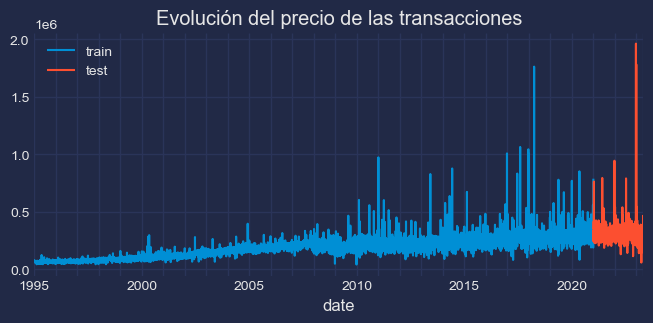

In [83]:
# --- Plot ---
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Evolución del precio de las transacciones')
ax.legend()
plt.show()

# Análisis exploratorio

## Estacionariedad

Una serie temporal se considera estacionaria si su media y su varianza se mantienen constantes en el tiempo. Por tanto, una serie temporal con tendencia o estacionalidad no es estacionaria. El modelo ARIMA asume que la serie temporal es estacionaria.

En caso de no ser estacionaria, diferenciamos la serie hasta conseguirlo, lo que nos ayuda a identificar el valor óptimo del parámetro $d$.

Para empezar, podemos ver en la figura anterior que existe una tendencia en la serie temporal y que la varianza no es constante. Por ejemplo, podemos ver que esta disminuye entorno a 2007 y 2021, y también se aprecia que aumenta alrededor de 2010. Por tanto, es muy probable que sea una serie temporal no estacionaria.

Ahora, vamos a aplicar tests estadísticos para confirmar esto:

Test stationarity for original series
-------------------------------------


C:\Users\domin\AppData\Local\Temp\ipykernel_2028\2638698216.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data)


ADF Statistic: -2.1274288465543125, p-value: 0.23362929174140906
KPSS Statistic: 16.636132152484752, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------


C:\Users\domin\AppData\Local\Temp\ipykernel_2028\2638698216.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data.diff().dropna())


ADF Statistic: -25.717128633802538, p-value: 0.0
KPSS Statistic: 0.07077391108220026, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------


C:\Users\domin\AppData\Local\Temp\ipykernel_2028\2638698216.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data.diff().diff().dropna())


ADF Statistic: -34.28933745606411, p-value: 0.0
KPSS Statistic: 0.031064469263295404, p-value: 0.1


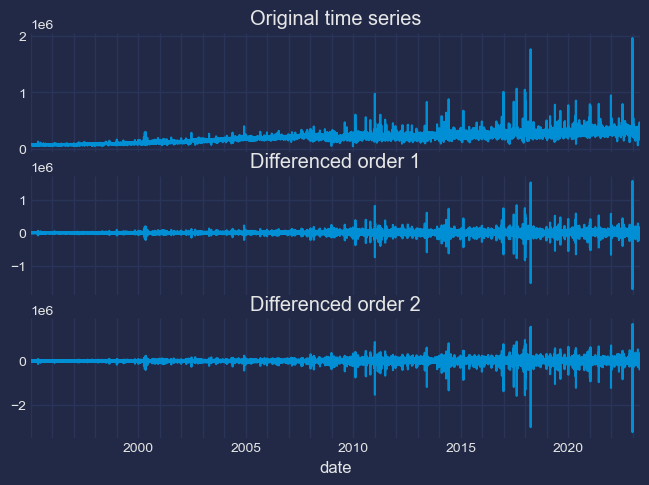

In [84]:
data_diff_1 = data.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data)
kpss_result = kpss(data)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');


Ya para el primer orden de diferenciación se consigue una disminución drástica del p-valor del estadístico ADF, que está incluso por debajo del aceptado umbral de $0.05$. Por tanto, el valor del parámetro $d$ más apropiado para un modelo ARIMA será $d=1$.

## Análisis de autocorrelación

Vamos a analizar la función de autocorrelación (ACF) y la de autocorrelación parcial (PACF) de la serie temporal. La primera nos ayudará a determinar el valor de $q$, mientras que la segunda el valor de $p$.

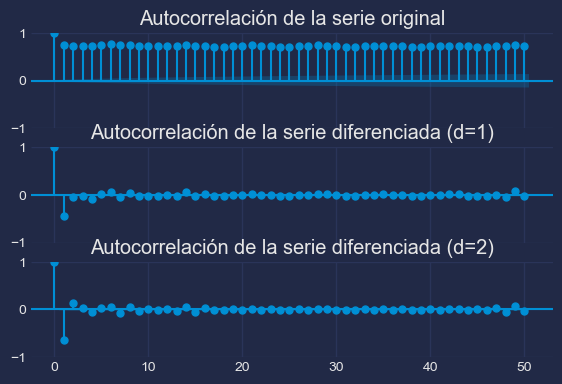

In [85]:
# Autocorrelation plot for original and differentiated series (d=1)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación de la serie original')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación de la serie diferenciada (d=1)')
plot_acf(data_diff_2, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Autocorrelación de la serie diferenciada (d=2)')
plt.show()

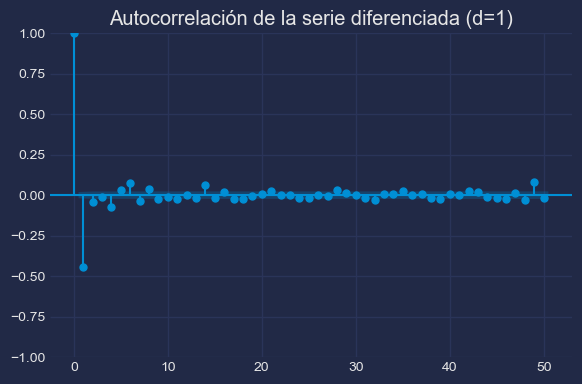

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data_diff_1, ax=axs, lags=50, alpha=0.05)
axs.set_title('Autocorrelación de la serie diferenciada (d=1)')
plt.show()

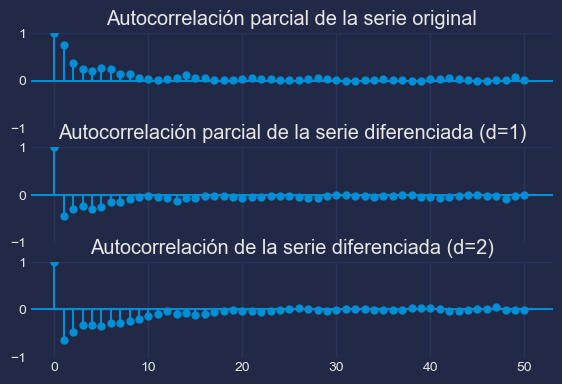

In [87]:
# Autocorrelation plot for original and differentiated series (d=1)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 4), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial de la serie original')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación parcial de la serie diferenciada (d=1)')
plot_pacf(data_diff_2, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Autocorrelación de la serie diferenciada (d=2)')
plt.show()

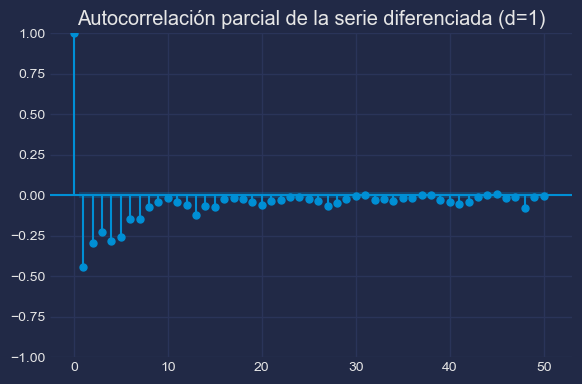

In [88]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True)
plot_pacf(data_diff_1, ax=axs, lags=50, alpha=0.05)
axs.set_title('Autocorrelación parcial de la serie diferenciada (d=1)')
plt.show()

Podemos sacar varias conclusiones:

+ El valor de $d$ elegido parece ser el correcto, ya que, además de estacionalizar la serie como vimos antes, al aumentarlo el se toman valores más negativos en los lags a partir del primero.

+ Centrándonos en la gráfica de autocorrelación orden 1, podemos ver que a partir del lag 1 se toman valores despreciable, por lo que podemos seleccionar el valor $q=1$.

+ Centrándonos en la gráfica de autocorrelación parcial de orden 1, vemos que hay un decaimiento pronunciado tras el segundo lag, por lo que podemos tomar $p=2$. Sin embargo, también podemos apreciar que más adelante vuelven a tomarse valores más altos y, además, al fijarnos en la parte final, vemos que se sigue un patrón oscilante. Esto podría ser indicativo de que hay una parte estacional con un efecto importante en la serie temporal.

## Descomposición de la serie temporal

Vamos a descomponer la serie temporal original en su tendencia, estacionalidad y residuos. La descomposición puede ser aditiva o multiplicativa (como puede verse un cambio de varianza a lo largo del tiempo, en principio se tiene un comportamiento multiplicativo). 
Esto nos ayudará a entender mejor la estructura interna de la serie temporal y a elegir mejor los parámetros del modelo ARIMA.

In [91]:
data

date
1995-01-01     63685.446429
1995-01-02     76743.308824
1995-01-03     65094.143678
1995-01-04     77713.120719
1995-01-05     78786.458088
                  ...      
2023-04-23    337221.383333
2023-04-24    299911.764706
2023-04-25    467076.923077
2023-04-26    246666.666667
2023-04-27    430000.000000
Freq: D, Name: Price, Length: 10344, dtype: float64

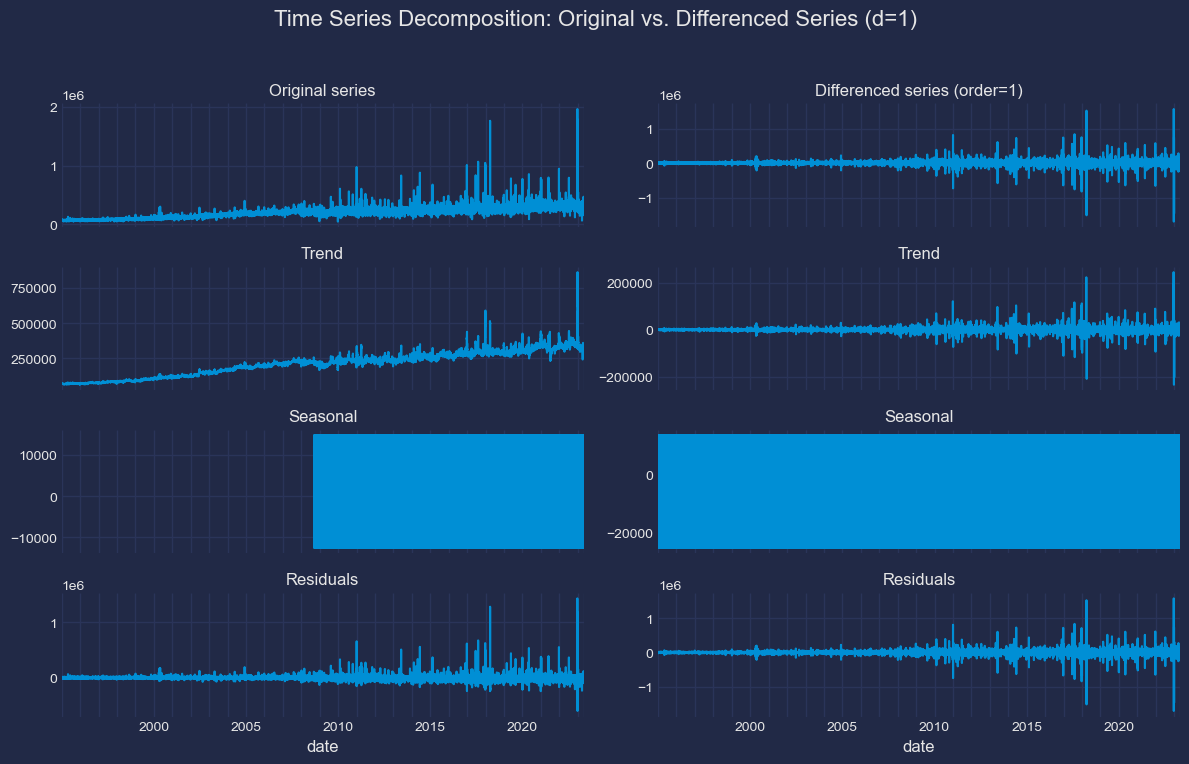

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the original series
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq')

# Decompose the first-differenced series
res_decompose_diff_1 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

# Plotting
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 8), sharex=True)

# Plot decomposition of the original series
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)

# Plot decomposition of the differenced series (d=1)
res_decompose_diff_1.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_decompose_diff_1.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_decompose_diff_1.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_decompose_diff_1.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)

# Adjust layout and show plot
fig.suptitle('Time Series Decomposition: Original vs. Differenced Series (d=1)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust space for the suptitle
plt.show()


<Axes: xlabel='date'>

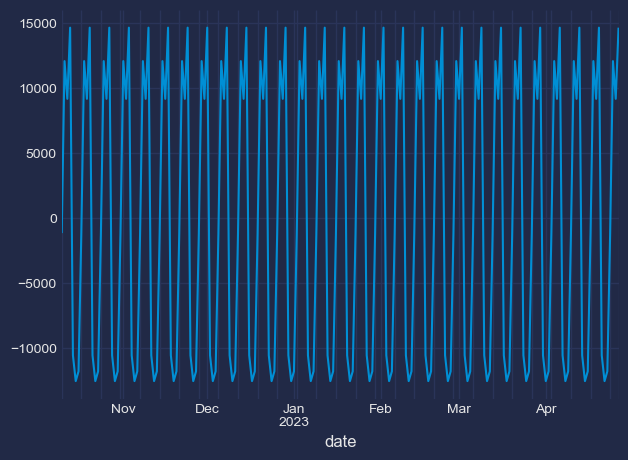

In [101]:
res_decompose.seasonal[-200:].plot()

Tenemos un patrón claro en la parte estacional de la serie temporal que se repite cada 12 meses. Concretamente, vemos que hay un bajón a principio de año, pero sube rápidamente y luego repunta de nuevo entorno a verano.

## Conclusión

En base a los resultados obtenidos, utilizar diferenciación de primer orden ($d=1$) junto con diferenciación estacional (7 días) es una buena aproximación al problema. 

In [102]:
# First-order differentiation combined with seasonal differentiation
# ==============================================================================
data_diff_1_12 = data_train.diff().diff(7).dropna()

adfuller_result = adfuller(data_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(data_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

ADF Statistic: -33.03389709023344, p-value: 0.0
KPSS Statistic: 0.03168716880541042, p-value: 0.1


C:\Users\domin\AppData\Local\Temp\ipykernel_2028\208865977.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data_diff_1_12)


# Modelo ARIMA y modelo SARIMAX

In [103]:
# ARIMA model with ForecasterSarimax and skforecast Sarimax
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), 
                                   seasonal_order=(1, 1, 1, 7))
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(data_test))
predictions.head(4)

2021-01-01    338451.459011
2021-01-02    339333.981694
2021-01-03    332923.286607
2021-01-04    354185.288869
Freq: D, Name: pred, dtype: float64

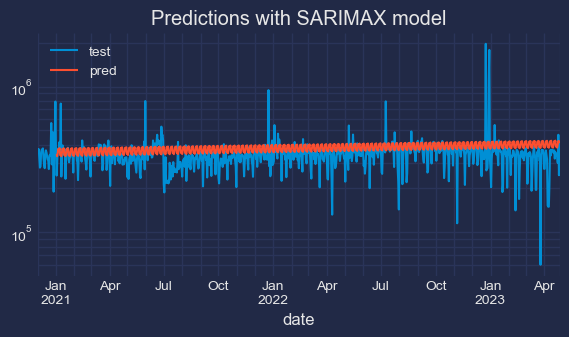

In [ ]:
# Plot predictions
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Predictions with SARIMAX model')
ax.set_yscale('log')
ax.legend();

## Backtesting

El backtesting en el contexto de series temporales es un método utilizado para evaluar la precisión de un modelo predictivo aplicándolo a datos históricos. La idea es probar cómo se habría desempeñado el modelo en el pasado para tener una estimación de su rendimiento en el futuro.

In [108]:
# Backtest forecaster
forecaster = ForecasterSarimax(
    regressor = Sarimax(
        order          = (2, 1, 1),
        seasonal_order =(1, 1, 1, 12),
        maxiter        = 200
    )
)
metric, predictions = backtesting_sarimax(
    forecaster = forecaster,
    y = data,
    initial_train_size = len(data_train),
    fixed_train_size = False,
    steps = 12,
    metric = 'mean_absolute_error',
    refit = True,
    n_jobs = "auto",
    suppress_warnings_fit = True,
    verbose = True,
    show_progress = True
)
display(metric)
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 9497
Number of observations used for backtesting: 847
    Number of folds: 71
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 7 observations.

Fold: 0
    Training:   1995-01-01 00:00:00 -- 2020-12-31 00:00:00  (n=9497)
    Validation: 2021-01-01 00:00:00 -- 2021-01-12 00:00:00  (n=12)
Fold: 1
    Training:   1995-01-01 00:00:00 -- 2021-01-12 00:00:00  (n=9509)
    Validation: 2021-01-13 00:00:00 -- 2021-01-24 00:00:00  (n=12)
Fold: 2
    Training:   1995-01-01 00:00:00 -- 2021-01-24 00:00:00  (n=9521)
    Validation: 2021-01-25 00:00:00 -- 2021-02-05 00:00:00  (n=12)
Fold: 3
    Training:   1995-01-01 00:00:00 -- 2021-02-05 00:00:00  (n=9533)
    Validation: 2021-02-06 00:00:00 -- 2021-02-17 00:00:00  (n=12)
Fold: 4
    Training:   1995-01-01 0

c:\Users\domin\anaconda3\Lib\site-packages\skforecast\model_selection_sarimax\model_selection_sarimax.py:204: LongTrainingWarning: The forecaster will be fit 71 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/71 [00:00<?, ?it/s]

,mean_absolute_error
0,46984.094057


,pred
2021-01-01,371709.240701
2021-01-02,354361.814927
2021-01-03,360333.128890
2021-01-04,343844.210527


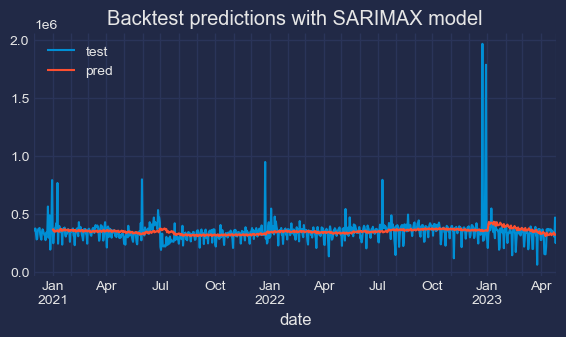

In [109]:
# Plot backtest predictions
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend()
plt.show()

# Ajuste de hiperparámetros

Gracias al estudio anterior, podemos centrarnos en el análisis de una cantidad de modelos sustancialmente inferior. El proceso de ajuste de hiperparámetros se realizará comparando métricas entre dichos modelos, tales como AIC o BIC y log-likelihood. No obstante, para verificar si el modelo final es verdaderamente un buen ajuste a los datos, vamos a recurrir al backtesting, que nos indicará su rendimiento en predicciones de modelos futuros.

Este ajuste de hiperparámetros inicial se realizará con un conjunto de validación.

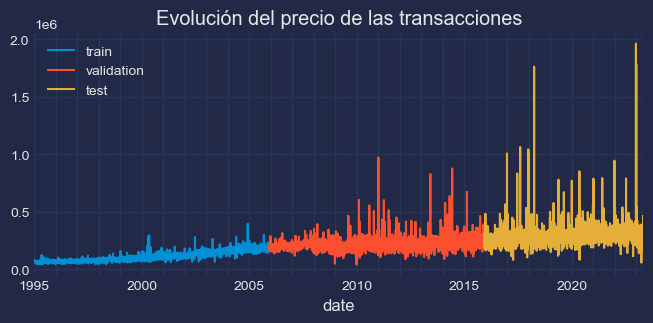

In [110]:
end_train = "2005-12-01"
end_val = "2015-12-01"

fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.set_title('Evolución del precio de las transacciones')
ax.legend()
plt.show()


In [111]:
# Grid search based on backtesting
forecaster = ForecasterSarimax(
    regressor = Sarimax(
        order   = (2, 1, 1), # Placeholder replaced in the grid search
        maxiter = 500
    )
)

param_grid = {
    'order': [(1, 1, 0), (1, 1, 1), (2, 1, 0), (2, 1, 1), (3, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data.loc[:end_train]),
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
results_grid.head(5)

Number of models compared: 45.


params grid:   0%|          | 0/45 [00:00<?, ?it/s]

c:\Users\domin\anaconda3\Lib\site-packages\skforecast\model_selection_sarimax\model_selection_sarimax.py:204: LongTrainingWarning: The forecaster will be fit 305 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
c:\Users\domin\anaconda3\Lib\site-packages\skforecast\model_selection_sarimax\model_selection_sarimax.py:204: LongTrainingWarning: The forecaster will be fit 305 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
c:\Users\domin\anaconda3\Lib\site-packages\skforecast\model_selection_sarimax\model_selection_sarimax.py:204: LongTrainingWarning: The forecaster will be fit 305 times. This can take substantial amounts of time. If not feasible, try with `refit = False

KeyboardInterrupt: 

También podemos evaluar basándonos en el AIC:

In [115]:
# Capture auto_arima trace in a pandas dataframe
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    # Auto arima: selection based on AIC
    model = auto_arima(
                y                 = data.loc[:end_val],
                start_p           = 0,
                start_q           = 0,
                max_p             = 3,
                max_q             = 3,
                seasonal          = True,
                test              = 'adf',
                m                 = 7, # Seasonal period
                d                 = None, # The algorithm will determine 'd'
                D                 = None, # The algorithm will determine 'D'
                trace             = True,
                error_action      = 'ignore',
                suppress_warnings = True,
                stepwise          = True
            )

trace_autoarima = buffer.getvalue()
pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([+-][\d\.]+), Time=([\d\.]+) sec"
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(
    matches, columns=["p", "d", "q", "P", "D", "Q", "m", "intercept", "AIC", "Time"]
)
results["order"] = results[["p", "d", "q"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1
)
results["seasonal_order"] = results[["P", "D", "Q", "m"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1
)
results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
results.sort_values(by="AIC", ascending=False).reset_index(drop=True)


,order,seasonal_order,intercept,AIC,Time


In [116]:
model

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 0, 1, 7),
      suppress_warnings=True)

In [ ]:
# Backtest predictions with the best model according to grid search
forecaster = ForecasterSarimax(
    regressor=Sarimax(order=(2, 0, 2), 
                    seasonal_order=(2, 0, 0, 12), 
                    maxiter=500),
)

metric_m1, predictions_m1 = backtesting_sarimax(
    forecaster            = forecaster,
    y                     = data,
    initial_train_size    = len(data.loc[:end_val]),
    steps                 = 12,
    metric                = 'mean_absolute_error',
    refit                 = True,
    n_jobs                = "auto",
    suppress_warnings_fit = True,
    verbose               = False,
    show_progress         = True
)

# Backtest predictions with the best model according to auto-arima
forecaster = ForecasterSarimax(
    regressor=Sarimax(order=(0, 1, 1), 
                    seasonal_order=(0, 0, 1, 12), 
                    maxiter=500),
)

metric_m2, predictions_m2 = backtesting_sarimax(
    forecaster            = forecaster,
    y                     = data,
    initial_train_size    = len(data.loc[:end_val]),
    steps                 = 12,
    metric                = 'mean_absolute_error',
    refit                 = True,
    n_jobs                = "auto",
    suppress_warnings_fit = True,
    verbose               = False,
    show_progress         = True
)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,39242.409146


Metric (mean_absolute_error) for auto arima-model:


,mean_absolute_error
0,44428.763354


c:\Users\domin\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


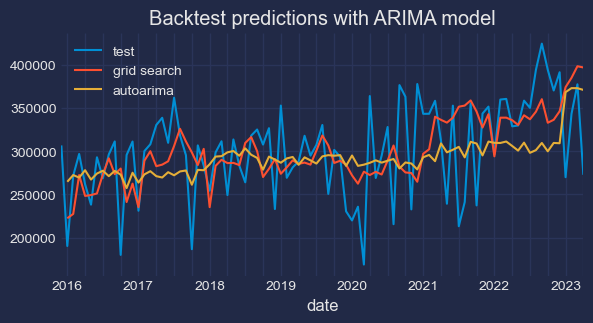

In [ ]:
# Compare predictions
print("Metric (mean_absolute_error) for grid search model:")
display(metric_m1)
print("Metric (mean_absolute_error) for auto arima-model:")
display(metric_m2)

fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_val:].plot(ax=ax, label='test')
predictions_m1 = predictions_m1.rename(columns={'pred': 'grid search'})
predictions_m2 = predictions_m2.rename(columns={'pred': 'autoarima'})
predictions_m1.plot(ax=ax)
predictions_m2.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

Los resultados de SARIMAX cuyos hiperparámetros fueron elegidos con backtesting son mejores. No obstante, Auto Arima es mucho más rápido de evaluar.

# Predicción hasta abril de 2024

Vamos a entrenar el modelo con los datos hasta finales de 2014 y, a continuación, utilizaremos este mismo modelo con los datos entre 2015 y abril del 2023 para predecir 1 año más.

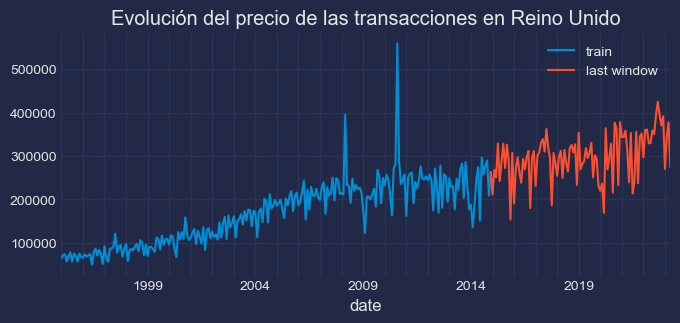

In [ ]:
# Split data Train - Last window
end_train = '2014-12-01'    
start_last_window = "2015-01-01"                   

fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='last window')
ax.set_title('Evolución del precio de las transacciones en Reino Unido')
ax.legend();

In [ ]:
# Train ARIMA forecaster with values from 1969-01-01 to 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
    regressor=Sarimax(order=(2, 1, 0), 
                    seasonal_order=(1, 1, 1, 12), 
                    maxiter=500),
)

forecaster.fit(y=data.loc[:end_train])

# Predict using last window
# ==============================================================================
predictions = forecaster.predict(
                  steps       = 12,
                  last_window = data.loc[start_last_window:]
              )
predictions.head(3)

2023-05-01    323733.916745
2023-06-01    331330.710071
2023-07-01    312973.240287
Freq: MS, Name: pred, dtype: float64

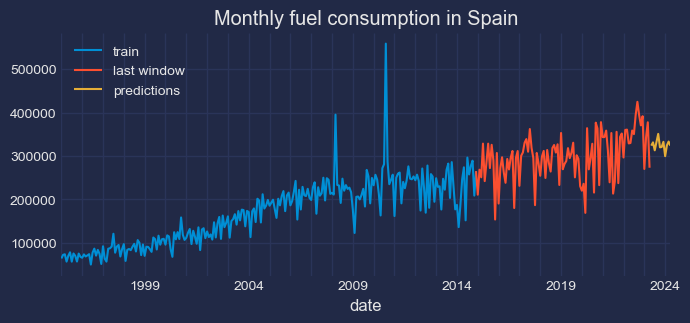

In [ ]:
# Plot predictions
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='last window')
predictions.plot(ax=ax, label='predictions')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Importancia de las variables

In [ ]:
importance = forecaster.get_feature_importances()
importance.head(10)

,feature,importance
4,sigma2,2.964239e+09
2,ar.S.L12,-2.927882e-02
1,ar.L2,-3.083249e-01
0,ar.L1,-6.702616e-01
3,ma.S.L12,-8.515307e-01


# Predicción de la evolución de categorías concretas

Usamos el mismo modelo encontrado para la predicción del precio para realizar predicciones de cada categoría por separado.

## Datos

Vamos a filtrar los datos por categorías. Por ejemplo, casos de alquiler, casos de ventas de propiedad, pisos o apartamentos, viviendas de segunda mano...

In [ ]:
def preprocess_data(data, property_type, duration, first_hand,
                    remove_outliers=True): 
    # Filter data
    mask_filter = ((data["org_property_type"] == property_type) 
            if property_type is not None else data["org_property_type"].notna()) & \
            ((data["org_duration"] == duration) 
            if duration is not None else data["org_duration"].notna()) & \
            ((data["First_hand"] == first_hand) 
            if first_hand is not None else data["First_hand"].notna())

    # Remove outlier
    if remove_outliers:
        mask_outliers = ((data["is_top_outlier"] != 1) | (data["is_bottom_outlier"] != 1))
    else:
        mask_outliers = pd.Series([True] * len(data), index=data.index)

    # Price
    mask = (mask_filter & mask_outliers)
    data = data.\
        loc[mask, ["Date.of.Transfer", "Price"]].\
        rename(columns={"Date.of.Transfer": "date"}).\
        groupby(["date"]).mean(numeric_only=True)
    
    return data

def load_filtered_parquets(property_type=None, duration=None, first_hand=None):
    # https://stackoverflow.com/questions/59098785/is-it-possible-to-read-parquet-files-in-chunks

    def load_parquet(path, property_type, duration, first_hand):
        parquet_file = pq.ParquetFile(path)
        n_batches_test = np.array([1 for _ in parquet_file.iter_batches()]).sum()

        for idx, batch in enumerate(parquet_file.iter_batches()):
            if idx == 0:
                data = preprocess_data(batch.to_pandas(), property_type, duration, first_hand).\
                    reset_index()
            
            else:
                batch_df = preprocess_data(batch.to_pandas(), property_type, duration, first_hand).\
                    reset_index()    
                data = pd.concat([data, batch_df], axis=0)

        return data.rename(columns={"Date.of.Transfer": "date"}).\
                    groupby(["date"]).mean(numeric_only=True)
        
    return (load_parquet('../../data/parquet/train/train.parquet', property_type, duration, first_hand)["Price"],
            load_parquet('../../data/parquet/test/test.parquet', property_type, duration, first_hand)["Price"])


In [ ]:
mapping = {
    "property_type": ["Adosado","Semi-adosado","Unifamiliar","Piso/Apartamento"],
    "duration": ["Propiedad","Alquiler"],
    "first_hand": [1, 0]
}


 Procesando las categorías de property_type...
{'property_type': 'Adosado'}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,57615.960938


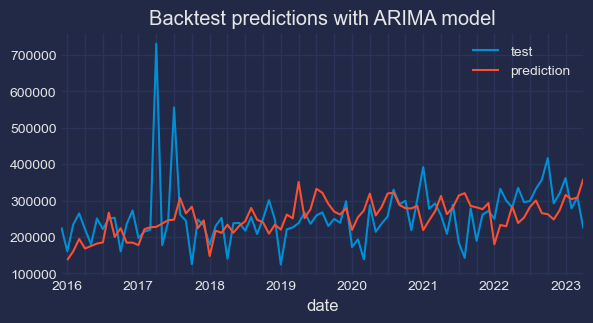

{'property_type': 'Semi-adosado'}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,43313.308761


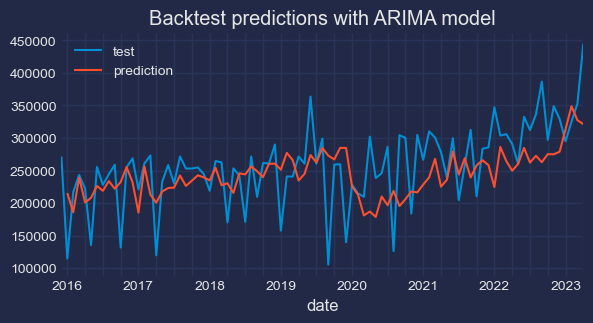

{'property_type': 'Unifamiliar'}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,93162.604533


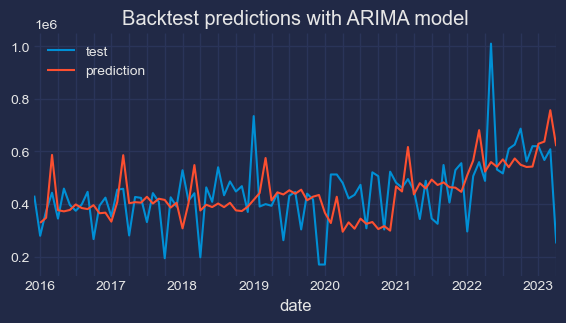

{'property_type': 'Piso/Apartamento'}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,59146.99635


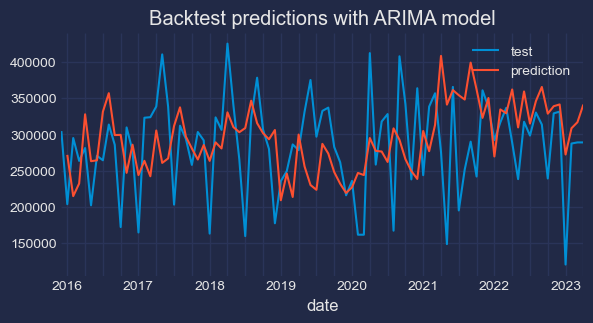


 Procesando las categorías de duration...
{'duration': 'Propiedad'}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,47920.259627


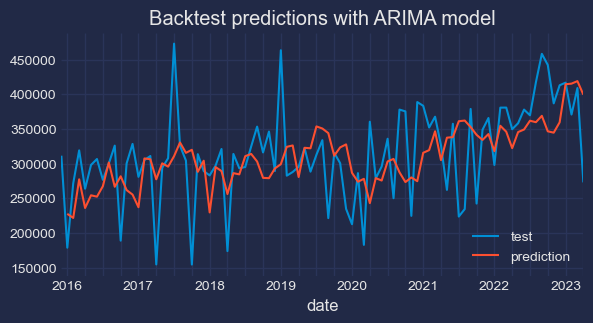

{'duration': 'Alquiler'}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,56215.047285


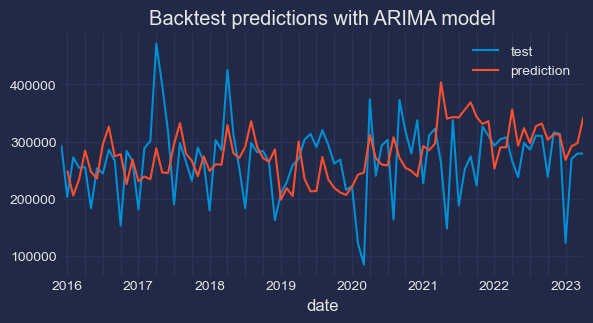


 Procesando las categorías de first_hand...
{'first_hand': 1}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,97270.916976


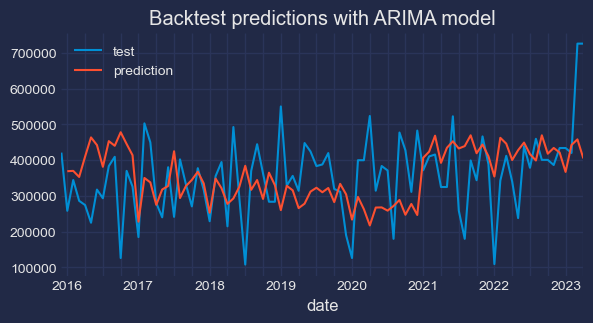

{'first_hand': 0}
Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,41738.819102


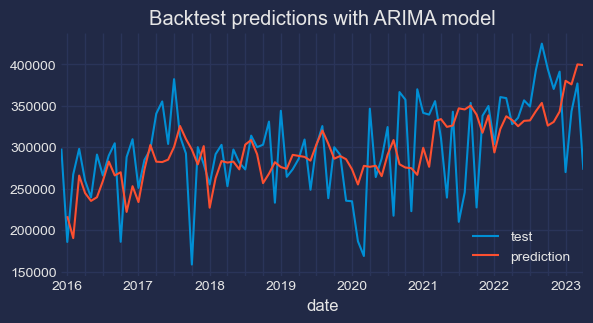

In [ ]:
def process_category(key, freq="MS", end_train="2005-12-01", end_val="2015-12-01"):
    columns_df = ["variable", "category", "mse"]
    error_metric = pd.DataFrame(columns=columns_df)
    filter={}

    for value in mapping[key]:
        filter[key] = value
        print(filter)

        # Prepare data
        (data_train, data_test) = load_filtered_parquets(**filter)
        data = pd.concat([data_train, data_test], axis=0)

        data = data.asfreq(freq).fillna(method='ffill') # fill first case if is NA too
        data_train = data_train.asfreq(freq).fillna(method='ffill') # fill first case if is NA too
        data_test = data_test.asfreq(freq).fillna(method='ffill') # fill first case if is NA too
        
        steps = data_test.shape[0]

        # Backtest predictions with the best model according to grid search
        forecaster = ForecasterSarimax(
            regressor=Sarimax(order=(2, 1, 0), 
                            seasonal_order=(1, 1, 1, 12), 
                            maxiter=500),
        )

        # Predictions
        metric, predictions = backtesting_sarimax(
            forecaster            = forecaster,
            y                     = data,
            initial_train_size    = len(data.loc[:end_val]),
            steps                 = 12,
            metric                = 'mean_absolute_error',
            refit                 = True,
            n_jobs                = "auto",
            suppress_warnings_fit = True,
            verbose               = False,
            show_progress         = False
        )

        # Save data
        temp = pd.DataFrame(data.loc[end_val:].copy())
        temp["pred"] = predictions
        temp.to_csv(f"../../output/series-temporales/{key}/{str(value).replace('/', '_')}.csv")

        # Write error data on df
        print("Metric (mean_absolute_error) for grid search model:")
        display(metric)
        error_metric = pd.concat([error_metric, 
                                  pd.DataFrame(columns=columns_df, data=[[key, value, metric.values[0][0]]])],
                                  axis=0)

        # Plot
        fig, ax = plt.subplots(figsize=(6, 3))
        temp.loc[:, "Price"].plot(ax=ax, label='test')
        temp.loc[:, "pred"].plot(ax=ax, label='prediction')
        ax.set_title('Backtest predictions with ARIMA model')
        ax.legend()
        plt.show()

    # Save error metrics
    error_metric.to_csv("../../output/series-temporales/error_metrics.csv")
        
for key in mapping.keys():
    ini_text = f"\n Procesando las categorías de {key}..."
    print(ini_text)
    print("=" * ( len(ini_text) ))
    process_category(key)